In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

In [2]:
#read Data
df = pd.read_csv('/Users/yashodhanjoglekar/Downloads/timesheet_report_2016-09-01_thru_2016-12-16.csv')

#Drop Null fields
df = df[pd.notnull(df['local_start_time'])]
df = df[pd.notnull(df['jobcode_2'])]

#convert to date time
df['start_time'] = pd.to_datetime(df['local_start_time'], format="%m/%d/%y %H:%M")
df['end_time'] = pd.to_datetime(df['local_end_time'], format="%m/%d/%y %H:%M")

#Geetdata where hours logged per person per entry are over 12
dfOT = df[df['hours'] >= 12]
##Geetdata where hours logged per person per entry are under 12
dfRT = df[df['hours'] <= 12]

#If number of hours logged are greater than 12, Replace with mean of all data under 12 hours
df['hours'] = df['hours'].apply( lambda x: dfRT['hours'].mean() if x >= 12 else x)

In [4]:
#Get earliest start time , latest end time 
project = df.groupby(['jobcode_2','jobcode_1']).agg({'start_time': np.min, 'end_time' : np.max, 'hours':np.sum})

#Calculated field - Project Duration
project['project_duration'] = ((project.end_time - project.start_time).astype('timedelta64[m]'))/60

#Get Day of week
project['start_day'] = project['start_time'].apply( lambda x: x.dayofweek)
project['end_day'] = project['end_time'].apply( lambda x: x.dayofweek)
project = project.reset_index().sort_values(by = 'start_time', ascending = True)
project.head(5)

,jobcode_2,jobcode_1,hours,start_time,end_time,project_duration,start_day,end_day
2,4378.0,MMLaFleur,14.92,2016-09-02 10:26:00,2016-09-12 18:03:00,247.616667,4,0
3,4382.0,Sephora,7.45,2016-09-05 12:00:00,2016-09-13 18:00:00,198.000000,0,1
4,4383.0,MMLaFleur,43.92,2016-09-06 10:07:00,2016-09-16 19:00:00,248.883333,1,4
5,4384.0,Alliance Time,11.77,2016-09-06 14:37:00,2016-09-15 18:24:00,219.783333,1,3
6,4386.0,Sephora,6.83,2016-09-12 11:28:00,2016-09-12 18:33:00,7.083333,0,0


In [5]:
#Filter projects between specific dates
start_date = pd.Timestamp('2016-10-01 00:00')
end_date = pd.Timestamp('2016-12-01 00:00')
mask = (project['start_time'] >= start_date) & (project['end_time'] <= end_date)
project.loc[mask]
project = project.loc[mask]

In [6]:
#read csv for quickbooks
invoice = pd.read_csv("/Users/yashodhanjoglekar/Downloads/view_invoice.csv")
invoice['Date'] = pd.to_datetime(invoice['Date'], format="%m/%d/%Y")

In [64]:
# Merge dataframes, match values from quickbooks with job codes
merged = project.merge(invoice, on='jobcode_2', how='left')
merged = merged[pd.notnull(merged['Amount'])]
merged['Images']= [75,121,55,186,50,91,4,160,72,53,2,102,40,5,195,125,9,92,108,102,47,102,20,87]
merged['TimePerImage'] = (merged.hours / merged.Images)*60 #In Minutes
merged['CostPerImage'] = (merged.Amount / merged.Images)
merged['EarningPerUnitTime'] = (merged.CostPerImage/ merged.TimePerImage)
merged.head()

,jobcode_2,jobcode_1,hours,start_time,end_time,project_duration,start_day,end_day,Date,Transaction_Type,Name,Due_Date,Amount,Open_Balance,Images,TimePerImage,CostPerImage,EarningPerUnitTime
0,4402.0,Sephora,10.16,2016-10-03 10:20:00,2016-10-04 12:32:00,26.200000,0,1,2016-10-10,Invoice,Sephora:4402,11/09/2016,1650.0,0.00,75,8.128000,22.0,2.706693
1,4400.0,Aerosoles,16.32,2016-10-03 15:09:00,2016-10-26 11:33:00,548.400000,0,2,2016-10-10,Invoice,Aerosoles:4400,11/09/2016,3025.0,0.00,121,8.092562,25.0,3.089257
3,4404.0,Alliance Time,5.22,2016-10-06 15:49:00,2016-10-10 16:06:00,96.283333,3,0,2016-11-02,Invoice,Alliance Time:4404,12/02/2016,990.0,0.00,55,5.694545,18.0,3.160920
4,4405.0,Sephora,22.79,2016-10-06 20:44:00,2016-10-15 16:12:00,211.466667,3,5,2016-10-21,Invoice,Sephora:4405,11/20/2016,4092.0,0.00,186,7.351613,22.0,2.992541
5,4407.0,Alliance Time,2.08,2016-10-12 16:16:00,2016-10-17 11:09:00,114.883333,2,0,2016-11-02,Invoice,Alliance Time:4407,12/02/2016,900.0,0.00,50,2.496000,18.0,7.211538


# Earning vs time

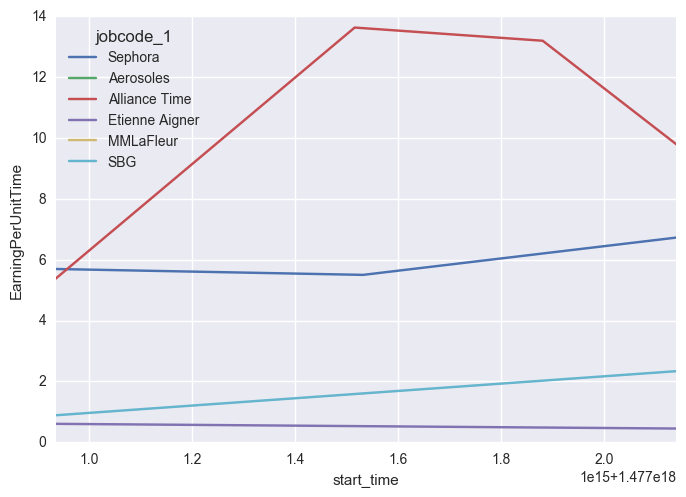

In [93]:
#Earning perminute over time
sns.tsplot(merged, time='start_time',condition ='jobcode_1',unit = 'Transaction_Type', value='EarningPerUnitTime')

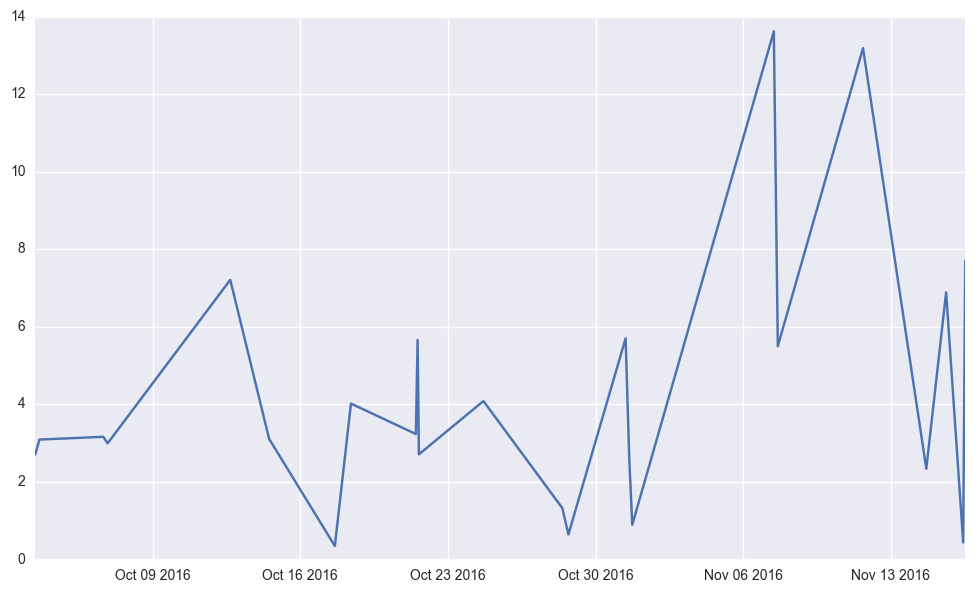

In [111]:
plt.figure(figsize=(12,7))
plt.plot(merged['start_time'].values, merged['EarningPerUnitTime'].values)

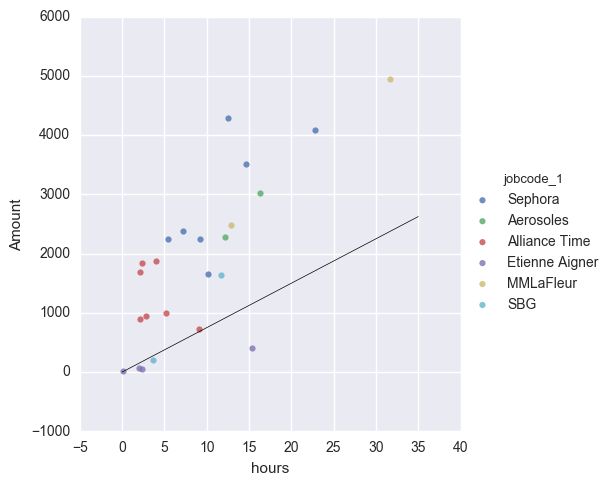

In [27]:
profitline = pd.DataFrame({ 'Hours' : np.arange(36)})
profitline['bill'] = profitline['Hours']*75
SearchMerged = merged[merged['jobcode_1']!= '']
sns.lmplot('hours','Amount',hue = 'jobcode_1', data=SearchMerged, fit_reg = False)
plt.plot(profitline.Hours,profitline.bill,c = 'k',lw='0.5') # plotting t,b separately 
sns.plt.show()

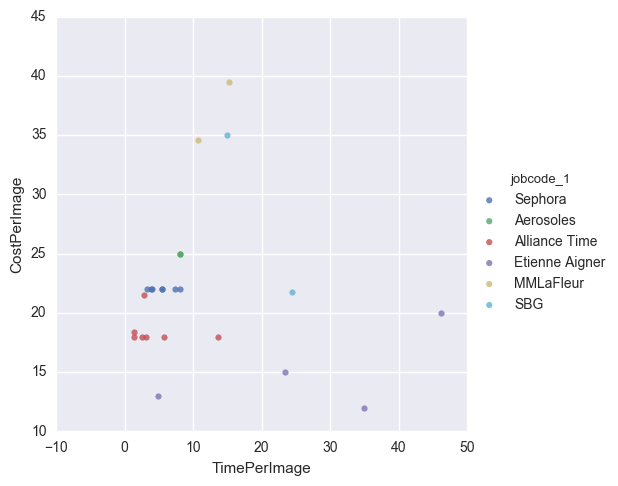

In [104]:
sns.lmplot('TimePerImage','CostPerImage',hue = 'jobcode_1', data=merged, fit_reg = False)
sns.plt.show()

# Aggregate Time by user name

In [95]:
#Aggregate hours by user name
userTime = df.groupby(['jobcode_2','username','jobcode_1']).agg({'hours':np.sum})
userTime = userTime.reset_index().sort_values(by = 'jobcode_2', ascending = True)
pivot = userTime.pivot(index='jobcode_2', columns='username', values='hours')
pivot.fillna(value=0, method=None, axis=None, inplace=True, limit=None, downcast=None)

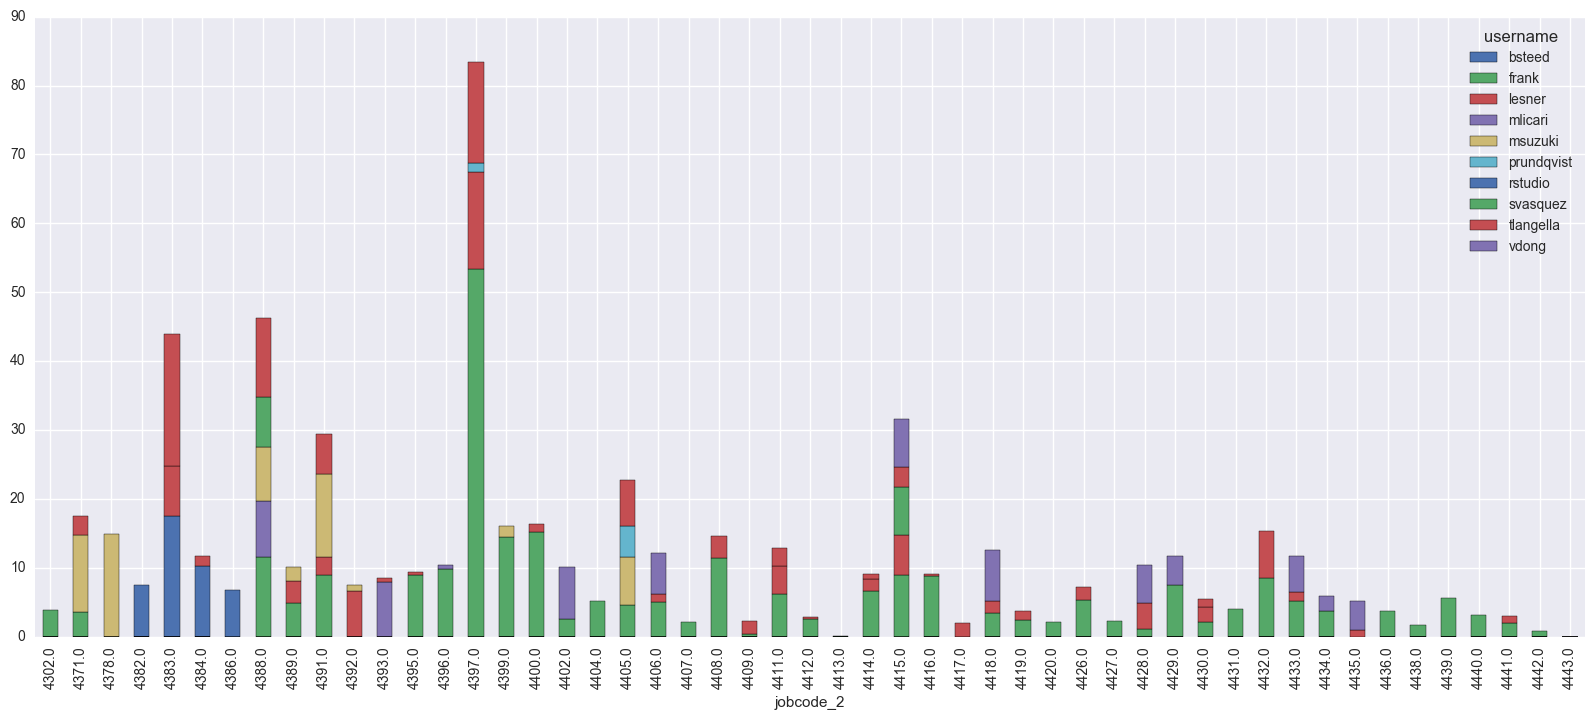

In [98]:
pivot.plot(kind = 'bar',stacked = True,figsize=(20, 8))

# Start Day for projects

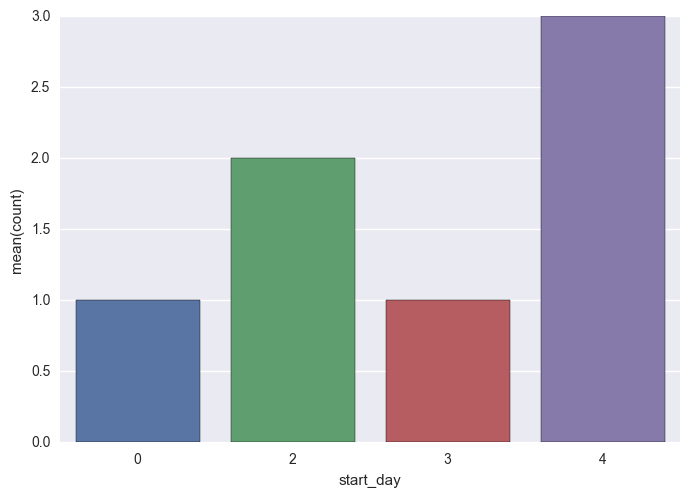

In [117]:
#The day of the week with Monday=0,Tuesday = 1,... Sunday=6
SearchMerged = merged[merged['jobcode_1']== "Alliance Time"] #Change name in "" to the required client
start_day_count = SearchMerged.groupby('start_day')['jobcode_2'].agg({'count'})
start_day_count = start_day_count.reset_index()
sns.barplot('start_day', 'count', data=start_day_count);